# Market Segmentation Case Study in Python
Kesarla ManiKanta Venkatesh | manikesarla@gmail.com

## 1. Import necessary Libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer

## 2. Loading the dataset

In [52]:
data = pd.read_csv("/content/sample_data/mcdonalds.csv")
data

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,No,Yes,No,Yes,Yes,No,No,No,Yes,No,Yes,I hate it!-5,47,Once a year,Male
1449,Yes,Yes,No,Yes,No,No,Yes,Yes,No,Yes,No,+2,36,Once a week,Female
1450,Yes,Yes,No,Yes,No,Yes,No,Yes,Yes,No,No,+3,52,Once a month,Female
1451,Yes,Yes,No,No,No,Yes,Yes,Yes,No,Yes,No,+4,41,Every three months,Male


The data set contains responses from **1453 adult Australian consumers** relating to their perceptions of McDonald’s

## 3. Exploring the Dataset

In [53]:
data.columns.tolist()

['yummy',
 'convenient',
 'spicy',
 'fattening',
 'greasy',
 'fast',
 'cheap',
 'tasty',
 'expensive',
 'healthy',
 'disgusting',
 'Like',
 'Age',
 'VisitFrequency',
 'Gender']

In [54]:
data.shape

(1453, 15)

In [55]:
data.head(3)

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female


Looking at the data quickly reveals that the segmentation variables (McDonald's perception) are not numerical but rather verbal.

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   yummy           1453 non-null   object
 1   convenient      1453 non-null   object
 2   spicy           1453 non-null   object
 3   fattening       1453 non-null   object
 4   greasy          1453 non-null   object
 5   fast            1453 non-null   object
 6   cheap           1453 non-null   object
 7   tasty           1453 non-null   object
 8   expensive       1453 non-null   object
 9   healthy         1453 non-null   object
 10  disgusting      1453 non-null   object
 11  Like            1453 non-null   object
 12  Age             1453 non-null   int64 
 13  VisitFrequency  1453 non-null   object
 14  Gender          1453 non-null   object
dtypes: int64(1), object(14)
memory usage: 170.4+ KB


In [57]:
print(pd.isnull(data).sum())

yummy             0
convenient        0
spicy             0
fattening         0
greasy            0
fast              0
cheap             0
tasty             0
expensive         0
healthy           0
disgusting        0
Like              0
Age               0
VisitFrequency    0
Gender            0
dtype: int64


In [58]:
data['yummy'].value_counts()

,count
yummy,
Yes,803
No,650


In [59]:
data['Like'].value_counts()

,count
Like,
+3,229
+2,187
0,169
+4,160
+1,152
I hate it!-5,152
I love it!+5,143
-3,73
-4,71


In [60]:
#For convinence renaming the category
data['Like']= data['Like'].replace({'I hate it!-5': '-5','I love it!+5':'+5'})

In [61]:
# Extract relevant columns
MD_x = data.iloc[:, 0:11]

# Convert "Yes" to 1, "No" to 0
MD_x = (MD_x == "Yes").astype(int)
# Calculating and rounding the column means
columnMeans = np.round(MD_x.mean(), 2)
columnHeadings = data.columns

# Printing the column headings with the corresponding rounded column means
result = dict(zip(columnHeadings, columnMeans))
print(result)

{'yummy': 0.55, 'convenient': 0.91, 'spicy': 0.09, 'fattening': 0.87, 'greasy': 0.53, 'fast': 0.9, 'cheap': 0.6, 'tasty': 0.64, 'expensive': 0.36, 'healthy': 0.2, 'disgusting': 0.24}


According to the average values of the transformed binary numeric segmentation variables, just ***9%*** of respondents think that McDonald's food is *Spicy*, whereas ***55%*** of respondents think that the restaurant's food is *Yummy* and ***91%*** think it's *Convenient*.

### Performing PCA

In [62]:
MD_pca = PCA()
MD_pca.fit(MD_x)

# Display PCA summary and components
print(pd.DataFrame({'Standard deviation': np.sqrt(MD_pca.explained_variance_),'Proportion of variance': MD_pca.explained_variance_ratio_, 'Cumulative Proportion:': np.cumsum(MD_pca.explained_variance_ratio_)}))

    Standard deviation  Proportion of variance  Cumulative Proportion:
0             0.757050                0.299447                0.299447
1             0.607456                0.192797                0.492244
2             0.504619                0.133045                0.625290
3             0.398799                0.083096                0.708386
4             0.337405                0.059481                0.767866
5             0.310275                0.050300                0.818166
6             0.289697                0.043849                0.862015
7             0.275122                0.039548                0.901563
8             0.265251                0.036761                0.938323
9             0.248842                0.032353                0.970677
10            0.236903                0.029323                1.000000


In [63]:
print("Standard deviations:")
print(np.round(MD_pca.explained_variance_, 1))
print("\nProportion of Variance:")
print(np.round(MD_pca.explained_variance_ratio_, 1))
print("\nCumulative Proportion:")
print(np.round(np.cumsum(MD_pca.explained_variance_ratio_), 1))

Standard deviations:
[0.6 0.4 0.3 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

Proportion of Variance:
[0.3 0.2 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0. ]

Cumulative Proportion:
[0.3 0.5 0.6 0.7 0.8 0.8 0.9 0.9 0.9 1.  1. ]


In [64]:
pca = PCA()
pc = pca.fit_transform(MD_x)

columnNames = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11']
pca_data = pd.DataFrame(data = pc, columns = columnNames)

print("\nRotation (n x k) = (11 x 11)\n")
pca_data


Rotation (n x k) = (11 x 11)



,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,-0.425367,0.219079,-0.663255,-0.401300,-0.201705,0.389767,-0.211982,-0.163235,-0.181007,-0.515706,0.567074
1,0.218638,-0.388190,0.730827,-0.094724,-0.044669,0.086596,-0.095877,0.034756,-0.111476,-0.493313,0.500440
2,-0.375415,-0.730435,0.122040,0.692262,-0.839643,0.687406,0.583112,-0.364379,0.322288,-0.061759,-0.242741
3,0.172926,0.352752,0.843795,0.206998,0.681415,0.036133,-0.054284,0.231477,0.028003,0.250678,0.051034
4,-0.187057,0.807610,-0.028537,0.548332,-0.854074,0.097305,-0.457043,-0.171758,0.074409,-0.031897,-0.082245
...,...,...,...,...,...,...,...,...,...,...,...
1448,-1.550242,-0.275031,0.013737,0.200604,0.145063,-0.306575,-0.075308,-0.345552,0.136589,0.432798,0.456076
1449,0.957339,-0.014308,-0.303843,0.444350,0.133690,-0.381804,-0.326432,-0.878047,0.304441,0.247443,0.193671
1450,0.185894,-1.062662,-0.220857,-0.467643,0.187757,0.192703,-0.091597,0.036576,-0.038255,-0.056518,0.012800
1451,1.182064,0.038570,-0.561561,0.701126,-0.047645,-0.193687,-0.027335,0.339374,-0.022267,0.002573,0.105316


The loadings indicate how the original variables are combined to form principal components.

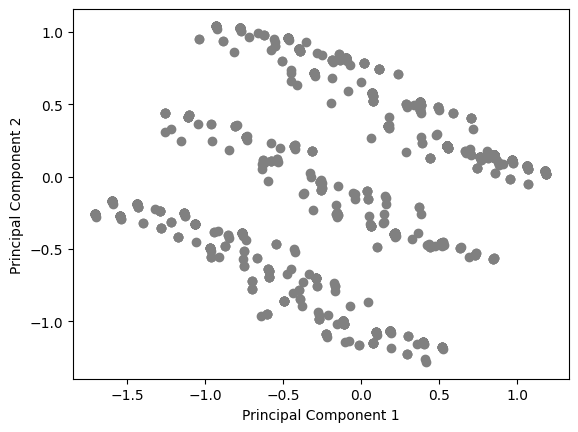

In [65]:
# Plot PCA results
plt.scatter(MD_pca.transform(MD_x)[:, 0], MD_pca.transform(MD_x)[:, 1], c="grey")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

For segment extraction, this first exploration provides insightful data. The findings show that some characteristics are highly correlated with one another and that price may be a key factor in separating distinct customer groups.

## 4. Extracting Segments

### 4.1 Using k-Means

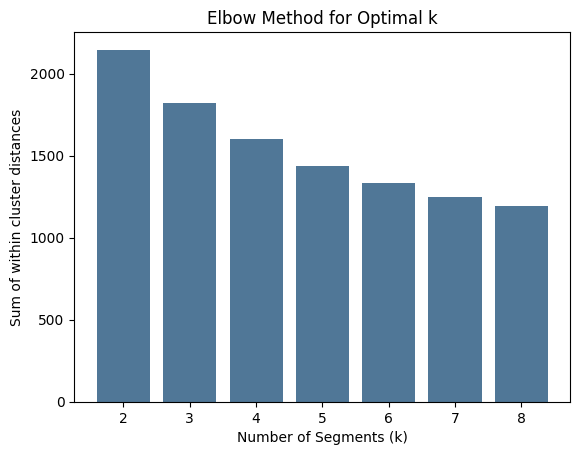

In [66]:
# Perform k-means clustering with k values from 2 to 8
k_values = range(2, 9)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    inertia_values.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.bar(k_values, inertia_values, color='#063e6b', alpha=0.7)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Segments (k)')
plt.ylabel('Sum of within cluster distances')
plt.show()

The sum of distances within market segments *drops slowly* as the *number of market segments increases*

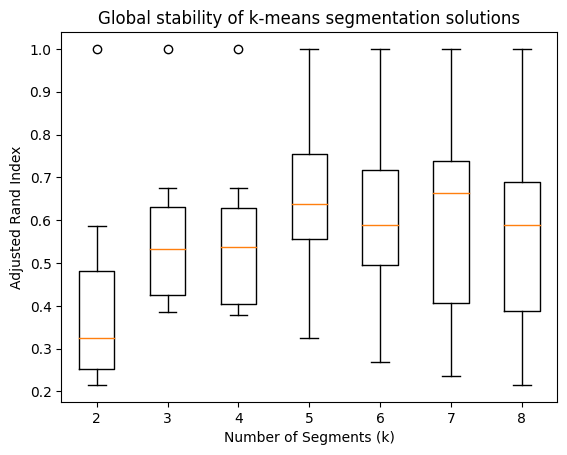

In [67]:
# Performing k-Means clustering for k values ranging from 2 to 8
results = {}
for k in range(2, 9):
    kmeans_model = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans_labels = kmeans_model.fit_predict(MD_x)
    results[str(k)] = kmeans_labels
    data['Cluster Number'] = kmeans_labels

# Calculating adjusted rand index for each k value
ari_values = []
for k1 in range(2, 9):
    ari_values.append([adjusted_rand_score(results[str(k1)], results[str(k2)]) for k2 in range(2, 9)])

# Convert ari_values to a NumPy array for easier plotting
ari_values = np.array(ari_values)

# Create a box plot
plt.boxplot(ari_values.T, labels=list(range(2, 9)))
plt.xlabel('Number of Segments (k)')
plt.ylabel('Adjusted Rand Index')
plt.title('Global stability of k-means segmentation solutions')
plt.show()

The distribution of stability for each number of segments is displayed in the vertical boxplots. The thick black horizontal line in the center of the box represents the median. More stability is preferable.

### 4.2 Using Mixtures of Distributions

In [68]:
columns = ["iter", "converged", "k", "k0", "logLik", "AIC", "BIC"]
results = pd.DataFrame(columns=columns)
X = np.array(MD_x)

# Perform Latent Class Analysis (LCA) using Gaussian Mixture Model
for k in range(2, 9):
    lca_model = GaussianMixture(n_components=k, n_init=10, random_state=1234)
    lca_model.fit(X)

    # Get log-likelihood and other metrics
    log_likelihood = lca_model.score(X)
    aic = lca_model.aic(X)
    bic = lca_model.bic(X)

    # Append the results to the DataFrame using pd.concat
    # Create a temporary DataFrame for the new row
    new_row = pd.DataFrame({"iter": [lca_model.n_iter_],
                           "converged": [True],
                           "k": [k],
                           "k0": [k],
                           "logLik": [log_likelihood],
                           "AIC": [aic],
                           "BIC": [bic]})
    # Concatenate the new row to the existing DataFrame
    results = pd.concat([results, new_row], ignore_index=True)
print(results)

<ipython-input-68-c18b312aaa3a>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


  iter converged  k k0     logLik           AIC           BIC
0    7      True  2  2   7.672279 -21985.641850 -21167.027072
1   12      True  3  3   9.722264 -27786.899425 -26556.336565
2   11      True  4  4  12.053367 -34405.083804 -32762.572863
3   18      True  5  5  15.485844 -44223.863382 -42169.404358
4    8      True  6  6  19.629761 -56110.084021 -53643.676917
5   18      True  7  7  20.407761 -58214.952914 -55336.597727
6   12      True  8  8  18.385967 -52183.620368 -48893.317099


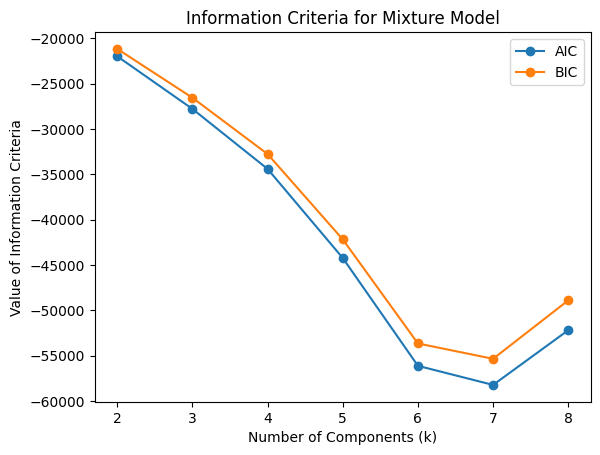

mixture    0    1    2    3
kmeans                     
0         31   51  268   14
1          4  214    0   22
2        143    0  362   28
3          0    3    0  313


In [69]:
# Latent Class Analysis using Gaussian Mixture Model
aicValues = []
bicValues = []

for k in range(2, 9):
    model = GaussianMixture(n_components=k, n_init=10, random_state=1234)
    model.fit(MD_x)
    aicValues.append(model.aic(MD_x))
    bicValues.append(model.bic(MD_x))

# Plot information criteria
plt.plot(range(2, 9), aicValues, label='AIC', marker='o')
plt.plot(range(2, 9), bicValues, label='BIC', marker='o')
plt.xlabel('Number of Components (k)')
plt.ylabel('Value of Information Criteria')
plt.legend()
plt.title('Information Criteria for Mixture Model')
plt.show()

# Select the model for k=4
selected_model = GaussianMixture(n_components=4, n_init=10, random_state=1234)
selected_model.fit(MD_x)

# Cross-tabulation of clusters from k-means and the mixture model
kmeans_model = KMeans(n_clusters=4, n_init=10, random_state=1234)
kmeans_labels = kmeans_model.fit_predict(MD_x)

cluster_comparison = pd.crosstab(index=kmeans_labels, columns=selected_model.predict(MD_x), rownames=['kmeans'], colnames=['mixture'])
print(cluster_comparison)

In [70]:
columns = ["iter", "converged", "k", "k0", "logLik", "AIC", "BIC"]
results = pd.DataFrame(columns=columns)  # or results = []
X = np.array(MD_x)

# Perform Latent Class Analysis (LCA) using Gaussian Mixture Model
for k in range(2, 9):
    lca_model = GaussianMixture(n_components=k, n_init=10, random_state=1234)
    lca_model.fit(X)

    # Get log-likelihood and other metrics
    log_likelihood = lca_model.score(X)
    aic = lca_model.aic(X)
    bic = lca_model.bic(X)

    # Append the results to the DataFrame using pd.concat
    # Create a temporary DataFrame for the new row
    new_row = pd.DataFrame({"iter": [lca_model.n_iter_],
                           "converged": [True],
                           "k": [k],
                           "k0": [k],
                           "logLik": [log_likelihood],
                           "AIC": [aic],
                           "BIC": [bic]})
    # Concatenate the new row to the existing DataFrame
    results = pd.concat([results, new_row], ignore_index=True)

print(results)

<ipython-input-70-46d782fd032e>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


  iter converged  k k0     logLik           AIC           BIC
0    7      True  2  2   7.672279 -21985.641850 -21167.027072
1   12      True  3  3   9.722264 -27786.899425 -26556.336565
2   11      True  4  4  12.053367 -34405.083804 -32762.572863
3   18      True  5  5  15.485844 -44223.863382 -42169.404358
4    8      True  6  6  19.629761 -56110.084021 -53643.676917
5   18      True  7  7  20.407761 -58214.952914 -55336.597727
6   12      True  8  8  18.385967 -52183.620368 -48893.317099


In [71]:
logLikelihood = selected_model.score_samples(MD_x)
print(f'Log Likelihood: {logLikelihood.sum()}')

Log Likelihood: 17513.541902228542


## 5. Profiling Segments

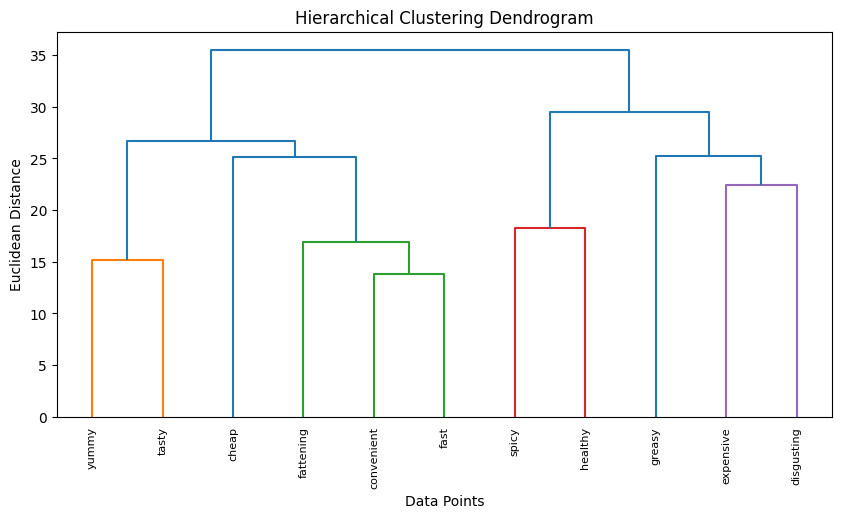

In [72]:
# Perform hierarchical clustering
MD_vclust = linkage(MD_x.transpose(), method='complete')

# Create a dendrogram to visualize the hierarchical clustering
plt.figure(figsize=(10, 5))
dendrogram(MD_vclust, labels=MD_x.columns, leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

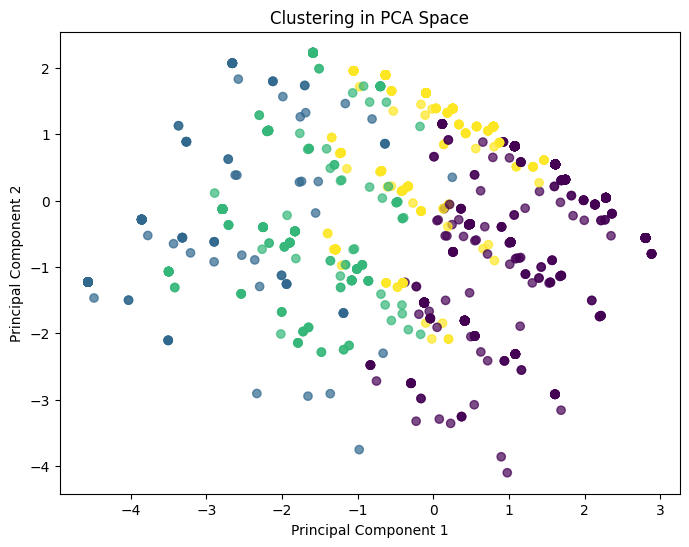

[[ 0.40695508  0.30882741  0.02332033 -0.17786071 -0.26779582  0.21303906
   0.28913434  0.42611499 -0.29094445  0.26683857 -0.41074387]
 [-0.28261487  0.04568172 -0.0699822   0.20559024  0.13630029  0.28244059
   0.57503178 -0.24219851 -0.56752776 -0.20103082  0.14388846]]


In [73]:
# Standardize the data
scaler = StandardScaler()
MD_x_standardized = scaler.fit_transform(MD_x)

# Perform PCA
pca = PCA(n_components=2)
MD_pca = pca.fit_transform(MD_x_standardized)

# Perform clustering (KMeans with k=4 for illustration)
kmeansModel = KMeans(n_clusters=4, random_state=1234)
MD_k4 = kmeansModel.fit_predict(MD_x_standardized)

# Visualize clustering in PCA space
plt.figure(figsize=(8, 6))
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], c=MD_k4, cmap='viridis', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Clustering in PCA Space")
plt.show()

# Project axes (MD.pca)
print(pca.components_)

## 6. Describing Segments

In [74]:
crosstab =pd.crosstab(data['Cluster Number'],data['Like'])
crosstab = crosstab[['-5','-4','-3','-2','-1','0','+1','+2','+3','+4','+5']]
crosstab

Like,-5,-4,-3,-2,-1,0,+1,+2,+3,+4,+5
Cluster Number,,,,,,,,,,,
0,5,3,6,4,5,17,25,27,37,19,20
1,11,16,20,17,17,41,19,22,15,1,0
2,0,0,1,0,2,4,9,12,30,25,31
3,69,24,19,13,9,26,7,4,4,0,0
4,2,2,3,7,14,27,33,45,46,42,35
5,1,1,1,4,2,11,13,28,25,22,17
6,62,22,21,12,5,15,7,6,1,0,0
7,2,3,2,2,4,28,39,43,71,51,40


### Creating a mosaic plots

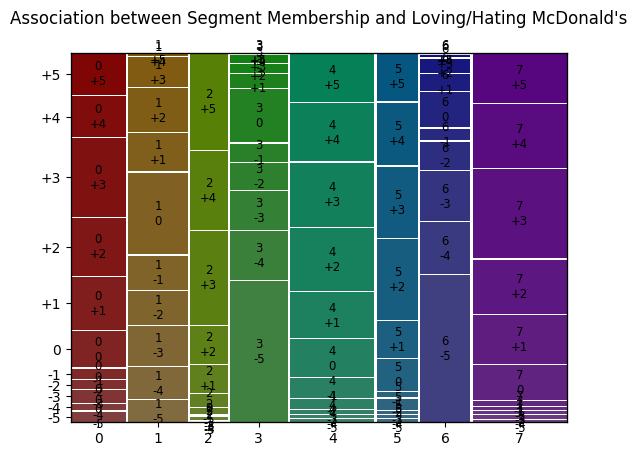

In [75]:
mosaic(crosstab.stack(), title='Association between Segment Membership and Loving/Hating McDonald\'s\n')
plt.show()

In [76]:
GenderCrossTab = pd.crosstab(data['Cluster Number'],data['Gender'])
GenderCrossTab

Gender,Female,Male
Cluster Number,,
0,84,84
1,98,81
2,62,52
3,75,100
4,149,107
5,59,66
6,87,64
7,174,111


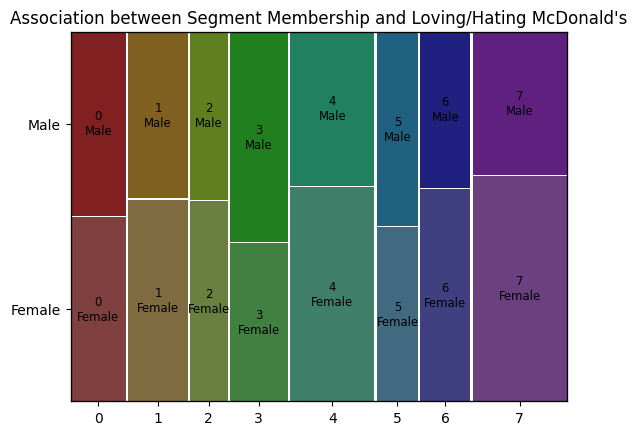

In [77]:
mosaic(GenderCrossTab.stack(), title='Association between Segment Membership and Loving/Hating McDonald\'s')
plt.show()

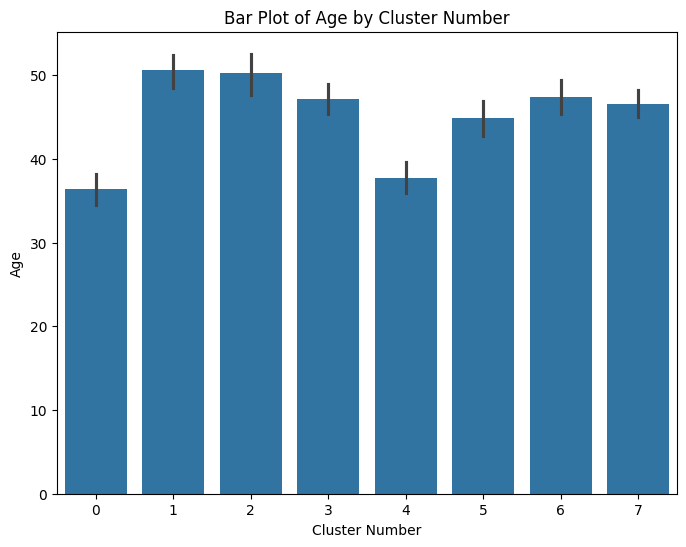

In [78]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Cluster Number', y='Age', data=data)
plt.xlabel('Cluster Number')
plt.ylabel('Age')
plt.title('Bar Plot of Age by Cluster Number')
plt.show()

## 7. Selecting (the) Target Segment(s)

### Calculating the mean for

#### 1. Visit frequency

In [79]:
data['VisitFrequency'] = LabelEncoder().fit_transform(data['VisitFrequency'])
visitFreq = data.groupby('Cluster Number')['VisitFrequency'].mean()
visitFreq = visitFreq.to_frame().reset_index()
visitFreq

,Cluster Number,VisitFrequency
0,0,2.583333
1,1,2.692737
2,2,2.491228
3,3,2.674286
4,4,2.656250
5,5,2.648000
6,6,2.774834
7,7,2.578947


#### 2. Like

In [80]:
data['Like'] = LabelEncoder().fit_transform(data['Like'])
like = data.groupby('Cluster Number')['Like'].mean()
like = like.to_frame().reset_index()
like

,Cluster Number,Like
0,0,3.380952
1,1,5.692737
2,2,2.877193
3,3,7.662857
4,4,3.281250
5,5,3.040000
6,6,7.523179
7,7,3.038596


#### 3. Gender

In [81]:
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])
gender = data.groupby('Cluster Number')['Gender'].mean()
gender = gender.to_frame().reset_index()
gender

,Cluster Number,Gender
0,0,0.500000
1,1,0.452514
2,2,0.456140
3,3,0.571429
4,4,0.417969
5,5,0.528000
6,6,0.423841
7,7,0.389474


In [82]:
clusters = gender.merge(like, on='Cluster Number', how='left').merge(visitFreq, on='Cluster Number', how='left')
clusters

,Cluster Number,Gender,Like,VisitFrequency
0,0,0.500000,3.380952,2.583333
1,1,0.452514,5.692737,2.692737
2,2,0.456140,2.877193,2.491228
3,3,0.571429,7.662857,2.674286
4,4,0.417969,3.281250,2.656250
5,5,0.528000,3.040000,2.648000
6,6,0.423841,7.523179,2.774834
7,7,0.389474,3.038596,2.578947


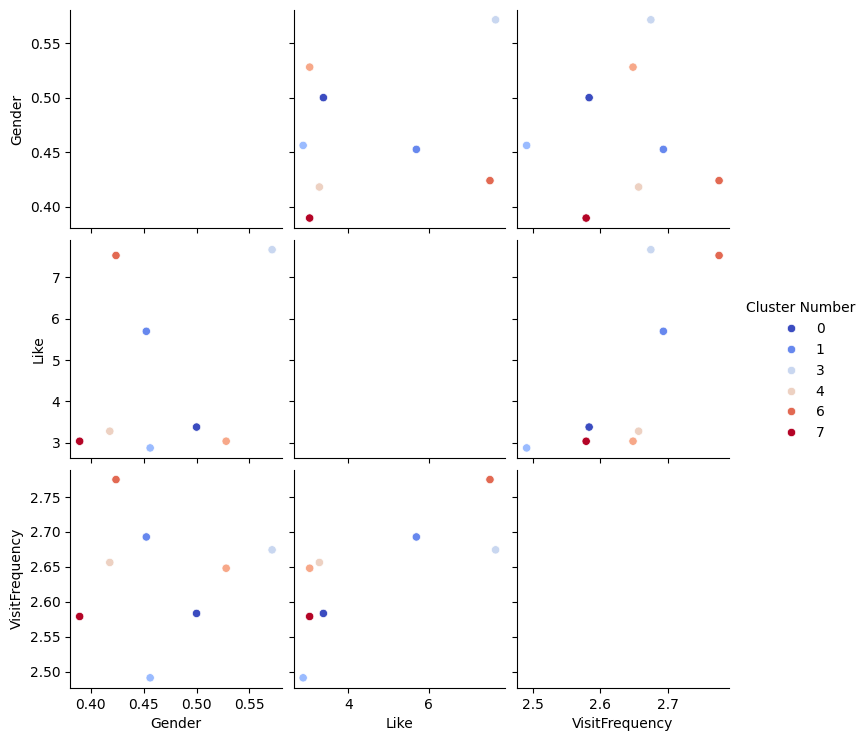

In [83]:
sns.pairplot(clusters, hue='Cluster Number', palette='coolwarm')
plt.show()

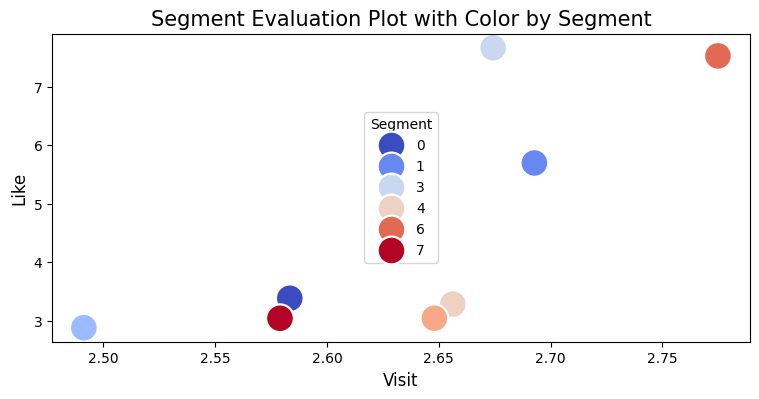

In [84]:
plt.figure(figsize=(9, 4))
sns.scatterplot(x="VisitFrequency", y="Like", data=clusters, s=400, hue='Cluster Number', palette='coolwarm')
plt.title("Segment Evaluation Plot with Color by Segment", fontsize=15)
plt.xlabel("Visit", fontsize=12)
plt.ylabel("Like", fontsize=12)
plt.legend(title='Segment', loc='center')
plt.show()

The following attractiveness criteria will be used:
- Liking McDonald’s
- Visit Frequency at McDonald’s.


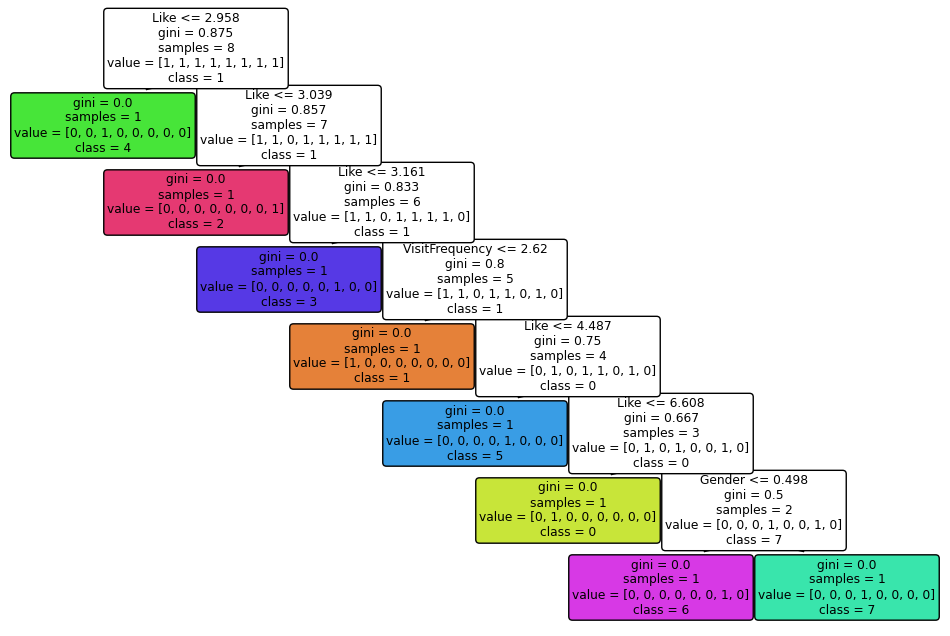

In [85]:
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
# Extract features and target variable
features = ['Like', 'VisitFrequency', 'Gender']
target = 'Cluster Number'

# Impute missing values
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(clusters[['Like', 'VisitFrequency', 'Gender']]), columns=['Like', 'VisitFrequency', 'Gender'])


# Separate features and target variable
X = data_imputed[features]  # Use the imputed data
y = clusters[target]

# Create a decision tree
tree = DecisionTreeClassifier()
tree.fit(X, y)

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=features, class_names=[str(i) for i in data[target].unique()], filled=True, rounded=True)
plt.show()

In [86]:
print(data_imputed.columns)
print(data['Cluster Number'].nunique())
print(len(features))

Index(['Like', 'VisitFrequency', 'Gender'], dtype='object')
8
3
